In [114]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [ ]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,-1.0,-1.0,71.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0


In [47]:
filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df['sequence_type'] == 'Non-Target', 'gesture'] = non_target_gestures[0]
agg_recipe = {
    "gesture": ["first"],
    "subject": ['first'],
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
}

filtered_df = filtered_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df['subject']
encoder = load_encoder(encoder_path, target_df)

target_tensor = torch.tensor(encoder.transform(target_df), dtype=torch.long)
features_tensor = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32)


target_gestures = full_df[full_df['sequence_type'] == 'Target']['gesture'].unique()
non_target_gestures = full_df[full_df['sequence_type'] == 'Non-Target']['gesture'].unique()
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

In [48]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(6, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
        )

    def forward(self, x: torch.Tensor):
        y_pred = self.fc(x)

        return y_pred


n_classes = len(encoder.classes_)
print(n_classes)

model = SimpleModel(n_classes).to(device)
dummy = torch.randn(2, 6)
model(dummy)

9


tensor([[-0.0545, -0.1239,  0.0962, -0.1725, -0.2886, -0.1352,  0.0408, -0.2531,
         -0.0994],
        [ 0.0007, -0.0748,  0.0395, -0.1135, -0.0659,  0.0137,  0.1570, -0.1093,
         -0.1329]], grad_fn=<AddmmBackward0>)

In [ ]:
def evaulate_model(model: nn.Module, X_test, y_test):
    model.eval()  # not sure if it's best practice to have this here or expect the model to come in eval mode
    y_pred = torch.argmax(model(X_test), dim=1)

    conf_matrix_result = confusion_matrix(y_test, y_pred)
    clsf_report_result = pd.DataFrame(classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)).T

    y_test_binary = torch.isin(y_test, target_gestures_encoded)
    y_pred_binary = torch.isin(y_pred, target_gestures_encoded)
    f1_binary = f1_score(y_test_binary, y_pred_binary, average="binary")
    
    f1_macro = f1_score(y_test, y_pred, average="macro")
    competition_evaluation = 0.5 * f1_binary + 0.5 * f1_macro

    return {
        "confusion_matrix": conf_matrix_result,
        "classification_report": clsf_report_result,
        "f1_binary": f1_binary,
        "f1_macro": f1_macro,
        "competition_evaluation": competition_evaluation,
    }


def train_model(model: nn.Module, dataloader: DataLoader, n_epochs: int, should_log=True):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(n_epochs):
        loss_avg = 0

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss_avg += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

        loss_avg = loss_avg / len(dataloader)
        if (epoch) % 20 == 0 and should_log:
            print(f"{epoch} - loss_avg: {loss_avg}")


# model = SimpleModel(n_classes)
# print(evaulate_model(model, features_tensor[:64], target_tensor[:64]))

In [ ]:
batch_size = 64
n_epochs = 50
n_splits = 5

gkf = GroupKFold(n_splits)

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_tensor, y=target_tensor, groups=subject_df)): # type: ignore
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = features_tensor[test_indices], target_tensor[test_indices]
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(n_classes).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test)
    folds_score.append(score_dashboard)

/tmp/ipykernel_135243/741365266.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.7618003464212604
20 - loss_avg: 1.3088447393155564
40 - loss_avg: 1.2634413779950608


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

0 - loss_avg: 1.7798299707618415
20 - loss_avg: 1.3504014751490425
40 - loss_avg: 1.2926380593402713


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

0 - loss_avg: 1.8173716804560494
20 - loss_avg: 1.34962597489357
40 - loss_avg: 1.2830958132650339


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

0 - loss_avg: 1.7695719108862036


In [185]:
def plot_cm(cm: np.ndarray, classes: list[str]) -> None:
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=80)
    plt.title("Confusion matrix")


def get_avg_fold(folds_score: list[dict[str, Any]]):
    f1_binary_avg = np.mean([fold["f1_binary"] for fold in folds_score])
    f1_macro_avg = np.mean([fold["f1_macro"] for fold in folds_score])
    competition_avg = np.mean([fold["competition_evaluation"] for fold in folds_score])
    confusion_matrix_avg = np.mean([fold["confusion_matrix"] for fold in folds_score], axis=0)

    reports = [fold["classification_report"] for fold in folds_score]
    reports_avg = pd.concat(reports).groupby(level=0).mean()

    return {
        "f1_binary": f1_binary_avg,
        "f1_macro": f1_macro_avg,
        "competition_evaluation": competition_avg,
        "confusion_matrix": confusion_matrix_avg,
        "classification_report": reports_avg,
    }

macro: 0.35, binary: 0.86, competition: 0.61


,precision,recall,f1-score,support
Above ear - pull hair,0.417452,0.370412,0.374563,127.600000
Cheek - pinch skin,0.264094,0.271562,0.264691,127.400000
Eyebrow - pull hair,0.276848,0.142609,0.186889,127.600000
Eyelash - pull hair,0.389346,0.384375,0.386261,128.000000
Forehead - pull hairline,0.358199,0.367188,0.360377,128.000000
Forehead - scratch,0.370189,0.454688,0.404902,128.000000
Neck - pinch skin,0.273774,0.262500,0.248204,128.000000
Neck - scratch,0.293092,0.128125,0.166204,128.000000
Write name on leg,0.737551,0.853835,0.791058,607.400000
accuracy,0.504902,0.504902,0.504902,0.504902


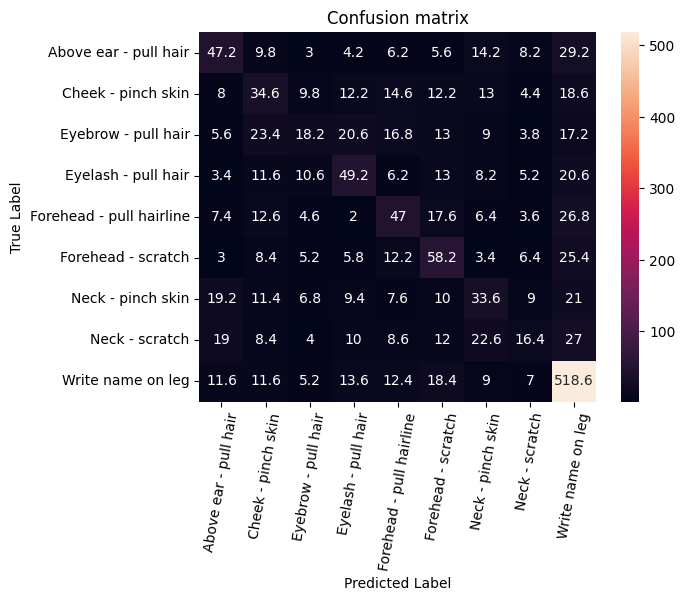

In [201]:
fold = get_avg_fold(folds_score)
# fold = folds_score[0]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

In [202]:
# final train model
n_epochs = 400
model = SimpleModel(n_classes)

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
